### data merge

In [1]:
import pandas as pd

facts_df = pd.read_csv("/home/liorkob/M.Sc/thesis/data/drugs_3k/gpt/processed_verdicts_with_gpt.csv")  # contains: verdict, extracted_gpt_facts
ranges_df = pd.read_csv("/home/liorkob/M.Sc/thesis/data/drugs_3k/gpt/punishment_range/punishment_ranges.csv")  # contains: file_name, low, high

# Clean file_name column (remove .csv extension)
ranges_df["verdict"] = ranges_df["file_name"].str.replace(".csv", "", regex=False)

# Merge on 'verdict'
merged_df = pd.merge(facts_df, ranges_df[["verdict", "low", "high"]], on="verdict", how="left")

# Remove duplicates – keep only one row per verdict
merged_df = merged_df.drop_duplicates(subset="verdict", keep="first")

# Save result
merged_df.to_csv("merged_output.csv", index=False)



df = pd.read_csv("merged_output.csv")
print("Total rows in CSV:", len(df))
print("Unique verdicts:", df["verdict"].nunique())
print("Unique extracted_gpt_facts:", df["extracted_gpt_facts"].nunique())


Total rows in CSV: 2987
Unique verdicts: 2987
Unique extracted_gpt_facts: 2971


In [2]:
print(df[["low", "high"]].describe())
print((df["low"] == df["high"]).mean())  # percent of equal ranges
df[df["extracted_gpt_facts"].duplicated(keep=False)].sort_values("extracted_gpt_facts")[["extracted_gpt_facts", "low", "high"]]


               low         high
count  2502.000000  2502.000000
mean     13.949241    28.672262
std      13.773581    21.116149
min       0.000000     2.000000
25%       6.000000    12.000000
50%       9.000000    22.000000
75%      18.000000    36.000000
max     144.000000   192.000000
0.03080013391362571


,extracted_gpt_facts,low,high
37,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,10.0,24.0
2550,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,NaN,NaN
2068,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,6.0,18.0
1993,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,NaN,NaN
1931,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,10.0,20.0
1842,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,NaN,NaN
2563,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,NaN,NaN
1246,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,NaN,NaN
1724,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,NaN,NaN
893,הנאשם הורשע על פי הודאתו בעבירות של החזקת חלק ...,24.0,48.0


In [3]:
import pandas as pd

# הסר שורות עם NaN ב-low או high
df = df.dropna(subset=["low", "high"])
len(df)

2502

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final")
# tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")

# Drop duplicates to get one fact per verdict
df_unique = df.drop_duplicates(subset=["verdict"])

token_lengths = df_unique["extracted_gpt_facts"].dropna().apply(
    lambda x: len(tokenizer.tokenize(str(x)))
)

print(f"Total unique samples: {len(token_lengths)}")
print(f">512 tokens: {(token_lengths > 512).sum()} ({100 * (token_lengths > 512).mean():.1f}%)")


Total unique samples: 2502
>512 tokens: 430 (17.2%)


### predict punishment range(after mlm ft)

In [5]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    BertPreTrainedModel
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import itertools

# ========= Load Data =========
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])
df["text"] = df["extracted_gpt_facts"]
df["labels"] = df[["low", "high"]].values.tolist()

# ========= Tokenizer =========
model_path = "/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final"
tokenizer = AutoTokenizer.from_pretrained(model_path)

# ========= Sliding Window Tokenization =========
def sliding_tokenize(text, tokenizer, max_length=512, stride=256):
    tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"][0]
    chunks = []
    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i+max_length]
        if len(chunk) < max_length:
            pad_len = max_length - len(chunk)
            chunk = torch.cat([chunk, torch.full((pad_len,), tokenizer.pad_token_id)])
        chunks.append(chunk.unsqueeze(0))
        if len(chunk) < max_length:
            break
    return torch.cat(chunks, dim=0)

# ========= Dataset =========
class PunishmentDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df["text"].tolist()
        self.labels = df["labels"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(text, return_tensors="pt", truncation=False)["input_ids"][0]
        if len(tokens) <= 512:
            input_ids = tokens.unsqueeze(0)
        else:
            input_ids = sliding_tokenize(text, self.tokenizer)
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": label
        }

# ========= Collate =========
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    labels = torch.stack([item["labels"] for item in batch])
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


def log_scaled_mse(pred, target):
    error = torch.abs(pred - target)
    return torch.mean(torch.log1p(error) * error ** 2)


# ========= Model =========
class HeBERTPunishmentRegressor(BertPreTrainedModel):
    def __init__(self, config, dropout_rate=0.3):
        super().__init__(config)
        self.bert = AutoModel.from_pretrained(model_path)
        self.low_regressor = nn.Linear(self.bert.config.hidden_size, 1)
        self.high_regressor = nn.Linear(self.bert.config.hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.init_weights()

    def forward(self, input_ids, attention_mask, labels=None):
        batch_cls = []
        for ids, mask in zip(input_ids, attention_mask):
            outputs = self.bert(input_ids=ids, attention_mask=mask)
            cls_tokens = outputs.last_hidden_state[:, 0, :]
            mean_cls = cls_tokens.mean(dim=0)
            batch_cls.append(mean_cls)

        pooled_output = torch.stack(batch_cls)
        x = self.dropout(pooled_output)
        low = self.low_regressor(x).squeeze(1)
        high = self.high_regressor(x).squeeze(1)
        logits = torch.stack([low, high], dim=1)

        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = log_scaled_mse(low, labels[:, 0]) + log_scaled_mse(high, labels[:, 1])
        else:
            loss = torch.tensor(0.0, device=x.device)  # ensures not None

        return {"loss": loss, "logits": logits}

# ========= Grid Search =========
# param_grid = {
#     "lr": [1e-5, 2e-5, 5e-5],
#     "dropout": [0.1, 0.3, 0.5],
#     "batch_size": [4, 8],
#     "epoch": [5, 10, 15]
# }
param_grid = {
    "lr": [1e-5],
    "dropout": [0.1],
    "batch_size": [4],
    "epoch": [15]
}


train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_mae = float("inf")
best_params = None

for lr, dropout, batch_size, num_epochs in itertools.product(
        param_grid["lr"], param_grid["dropout"], param_grid["batch_size"], param_grid["epoch"]):

    print(f"\n🔧 Running config: lr={lr}, dropout={dropout}, batch_size={batch_size}, epochs={num_epochs}")
    train_dataset = PunishmentDataset(train_df, tokenizer)
    test_dataset = PunishmentDataset(test_df, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    config = AutoConfig.from_pretrained(model_path)
    model = HeBERTPunishmentRegressor(config).to(device)
    model.dropout.p = dropout
    optimizer = AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_ids = [b.to(device) for b in batch["input_ids"]]
            attention_mask = [b.to(device) for b in batch["attention_mask"]]
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} Training Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = [b.to(device) for b in batch["input_ids"]]
            attention_mask = [b.to(device) for b in batch["attention_mask"]]
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = outputs["logits"].cpu().numpy()
            preds.append(pred)
            trues.append(labels.cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
# ========= Evaluation Metrics =========
low_true = trues[:, 0]
high_true = trues[:, 1]
low_pred = preds[:, 0]
high_pred = preds[:, 1]

# --- טולרנס: טעות עד 2 חודשים ---
tolerance = 2
low_within_tolerance = np.mean(np.abs(low_pred - low_true) <= tolerance)
high_within_tolerance = np.mean(np.abs(high_pred - high_true) <= tolerance)

print(f"🔸 LOW Accuracy ±{tolerance} months: {low_within_tolerance:.2%}")
print(f"🔸 HIGH Accuracy ±{tolerance} months: {high_within_tolerance:.2%}")

# --- טעות חמורה (יותר מ-5 חודשים) ---
severe_low = np.mean(np.abs(low_pred - low_true) > 5)
severe_high = np.mean(np.abs(high_pred - high_true) > 5)

print(f"🚨 LOW Severe Errors (>5 months): {severe_low:.2%}")
print(f"🚨 HIGH Severe Errors (>5 months): {severe_high:.2%}")

# --- Percentiles של שגיאות ---
low_errors = np.abs(low_pred - low_true)
high_errors = np.abs(high_pred - high_true)

print("📊 LOW Error Percentiles (25/50/75/90/95%):", np.percentile(low_errors, [25, 50, 75, 90, 95]))
print("📊 HIGH Error Percentiles (25/50/75/90/95%):", np.percentile(high_errors, [25, 50, 75, 90, 95]))

# --- מדדים סטנדרטיים ---
print("\n🔹 LOW Prediction:")
print("MSE:", mean_squared_error(low_true, low_pred))
print("MAE:", mean_absolute_error(low_true, low_pred))
print("R²:", r2_score(low_true, low_pred))

print("\n🔹 HIGH Prediction:")
print("MSE:", mean_squared_error(high_true, high_pred))
print("MAE:", mean_absolute_error(high_true, high_pred))
print("R²:", r2_score(high_true, high_pred))


2025-06-11 22:35:45.660322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 22:35:45.670259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749670545.679680 1664649 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749670545.682477 1664649 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749670545.691242 1664649 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


🔧 Running config: lr=1e-05, dropout=0.1, batch_size=4, epochs=10


Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 450/450 [00:46<00:00,  9.68it/s]


Epoch 1 Training Loss: 3775.1008


Epoch 2/10: 100%|██████████| 450/450 [00:39<00:00, 11.45it/s]


Epoch 2 Training Loss: 3214.0394


Epoch 3/10: 100%|██████████| 450/450 [00:39<00:00, 11.42it/s]


Epoch 3 Training Loss: 2931.7082


Epoch 4/10: 100%|██████████| 450/450 [00:39<00:00, 11.41it/s]


Epoch 4 Training Loss: 2706.5313


Epoch 5/10: 100%|██████████| 450/450 [00:39<00:00, 11.41it/s]


Epoch 5 Training Loss: 2539.9105


Epoch 6/10: 100%|██████████| 450/450 [00:39<00:00, 11.39it/s]


Epoch 6 Training Loss: 2415.3683


Epoch 7/10: 100%|██████████| 450/450 [00:39<00:00, 11.38it/s]


Epoch 7 Training Loss: 2336.5391


Epoch 8/10: 100%|██████████| 450/450 [00:39<00:00, 11.38it/s]


Epoch 8 Training Loss: 2146.1524


Epoch 9/10: 100%|██████████| 450/450 [00:39<00:00, 11.36it/s]


Epoch 9 Training Loss: 1920.1214


Epoch 10/10: 100%|██████████| 450/450 [00:39<00:00, 11.38it/s]


Epoch 10 Training Loss: 1695.0699
🔸 LOW Accuracy ±2 months: 28.34%
🔸 HIGH Accuracy ±2 months: 13.97%
🚨 LOW Severe Errors (>5 months): 44.11%
🚨 HIGH Severe Errors (>5 months): 64.67%
📊 LOW Error Percentiles (25/50/75/90/95%): [ 1.69537735  4.35797405  8.35491943 16.71979523 27.89423752]
📊 HIGH Error Percentiles (25/50/75/90/95%): [ 3.77430344  6.87820244 16.59095192 30.28578186 44.08854675]

🔹 LOW Prediction:
MSE: 128.42657470703125
MAE: 7.1679368019104
R²: 0.2654914855957031

🔹 HIGH Prediction:
MSE: 364.7908630371094
MAE: 12.560639381408691
R²: 0.1435754895210266


### predict punishent range with no mlm ft

In [6]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    BertPreTrainedModel,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# ========= Load Data =========
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])
df["text"] = df["extracted_gpt_facts"]
df["labels"] = df[["low", "high"]].values.tolist()

# ========= Tokenizer =========
model_path = "avichr/heBERT"  
tokenizer = AutoTokenizer.from_pretrained(model_path)

# ========= Sliding Window Tokenization =========
def sliding_tokenize(text, tokenizer, max_length=512, stride=256):
    tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"][0]
    chunks = []
    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i+max_length]
        if len(chunk) < max_length:
            pad_len = max_length - len(chunk)
            chunk = torch.cat([chunk, torch.full((pad_len,), tokenizer.pad_token_id)])
        chunks.append(chunk.unsqueeze(0))
        if len(chunk) < max_length:
            break
    return torch.cat(chunks, dim=0)

# ========= Dataset =========
class PunishmentDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df["text"].tolist()
        self.labels = df["labels"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_ids = sliding_tokenize(self.texts[idx], self.tokenizer)
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": label
        }

# ========= Collate =========
def collate_fn(batch):
    input_ids = [torch.mean(x["input_ids"].float(), dim=0) for x in batch]
    attention_mask = [torch.mean(x["attention_mask"].float(), dim=0) for x in batch]
    labels = torch.stack([x["labels"] for x in batch])
    return {
        "input_ids": torch.stack(input_ids).long(),
        "attention_mask": torch.stack(attention_mask).long(),
        "labels": labels
    }

# ========= Model =========
class HeBERTPunishmentRegressor(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = AutoModel.from_pretrained(model_path, config=config)
        self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(config.hidden_size, 2)
        self.init_weights()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_output)
        logits = self.regressor(x)
        loss = nn.MSELoss()(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits}

# ========= Prepare Data =========
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_dataset = PunishmentDataset(train_df, tokenizer)
val_dataset = PunishmentDataset(val_df, tokenizer)
test_dataset = PunishmentDataset(test_df, tokenizer)

# ========= Training Arguments =========
training_args = TrainingArguments(
    output_dir="./hebert-punishment",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

# ========= Train =========
config = AutoConfig.from_pretrained(model_path)
model = HeBERTPunishmentRegressor(config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn
)

trainer.train()

# ========= Save =========
model.save_pretrained("./hebert-3k-drugs-punishment/final")
tokenizer.save_pretrained("./hebert-3k-drugs-punishment/final")

# ========= Evaluation =========
print("\n✅ Evaluation on Test Set")
predictions = trainer.predict(test_dataset).predictions
true = np.vstack(test_df["labels"].values)

print("📉 MSE:", mean_squared_error(true, predictions))
print("📏 MAE:", mean_absolute_error(true, predictions))
print("📊 R2:", r2_score(true, predictions))


/home/liorkob/.conda/envs/new_env/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### baseline- mean

In [ ]:
low_mean = df["low"].mean()
high_mean = df["high"].mean()

baseline_preds = np.array([[low_mean, high_mean]] * len(test_df))
true = np.vstack(test_df["labels"].values)

print("🔹 Baseline:")
print("MSE:", mean_squared_error(true, baseline_preds))
print("MAE:", mean_absolute_error(true, baseline_preds))
print("R2:", r2_score(true, baseline_preds))

### 2 models!

In [ ]:
# import pandas as pd
# import torch
# import numpy as np
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from transformers import (
#     AutoTokenizer,
#     AutoModel,
#     AutoConfig,
#     BertPreTrainedModel
# )
# from torch.optim import AdamW
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from tqdm import tqdm
# import os

# # ========== הגדרת מודל וטוקניזר שכבר עברו fine-tuning ==========
# finetuned_model_path = "/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final"
# tokenizer = AutoTokenizer.from_pretrained(finetuned_model_path)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ========== פונקציית Tokenization Sliding Window ==========
# def sliding_tokenize(text, tokenizer, max_length=512, stride=256):
#     tokens = tokenizer(text, return_tensors="pt", truncation=False)["input_ids"][0]
#     chunks = []
#     for i in range(0, len(tokens), stride):
#         chunk = tokens[i:i+max_length]
#         if len(chunk) < max_length:
#             pad_len = max_length - len(chunk)
#             chunk = torch.cat([chunk, torch.full((pad_len,), tokenizer.pad_token_id)])
#         chunks.append(chunk.unsqueeze(0))
#         if len(chunk) < max_length:
#             break
#     return torch.cat(chunks, dim=0)

# # ========== Dataset ==========
# class SingleTargetDataset(Dataset):
#     def __init__(self, df, tokenizer, target_col):
#         self.texts = df["text"].tolist()
#         self.labels = df[target_col].tolist()
#         self.tokenizer = tokenizer

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         chunks = sliding_tokenize(text, self.tokenizer)
#         attention_mask = (chunks != self.tokenizer.pad_token_id).long()
#         label = torch.tensor(self.labels[idx], dtype=torch.float)
#         return {
#             "input_ids": chunks,
#             "attention_mask": attention_mask,
#             "labels": label
#         }

# # ========== Collate ==========
# def collate_fn(batch):
#     return {
#         "input_ids": [x["input_ids"] for x in batch],
#         "attention_mask": [x["attention_mask"] for x in batch],
#         "labels": torch.stack([x["labels"] for x in batch])
#     }

# # ========== Loss Function ==========
# def log_scaled_mse(pred, target):
#     error = torch.abs(pred - target)
#     return torch.mean(torch.log1p(error) * error ** 2)

# # ========== Regression Model ==========
# class HeBERTSingleRegressor(BertPreTrainedModel):
#     def __init__(self, config, bert_model_path, dropout_rate=0.3):
#         super().__init__(config)
#         self.bert = AutoModel.from_pretrained(bert_model_path)
#         self.regressor = nn.Linear(self.bert.config.hidden_size, 1)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.init_weights()

#     def forward(self, input_ids, attention_mask, labels=None):
#         batch_cls = []
#         for ids, mask in zip(input_ids, attention_mask):
#             ids = ids.to(self.device)
#             mask = mask.to(self.device)
#             outputs = self.bert(input_ids=ids, attention_mask=mask)
#             cls_tokens = outputs.last_hidden_state[:, 0, :]
#             mean_cls = cls_tokens.mean(dim=0)
#             batch_cls.append(mean_cls)

#         pooled_output = torch.stack(batch_cls)
#         x = self.dropout(pooled_output)
#         prediction = self.regressor(x).squeeze(1)

#         loss = log_scaled_mse(prediction, labels) if labels is not None else torch.tensor(0.0, device=x.device)
#         return {"loss": loss, "logits": prediction}

# # ========== Load Data ==========
# df = pd.read_csv("merged_output.csv")
# df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])
# df["text"] = df["extracted_gpt_facts"]

# # ========== Training Loop for both LOW and HIGH ==========
# for target_col in ["low", "high"]:
#     print(f"\n=== 🔧 Training for: {target_col.upper()} ===")

#     train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
#     train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

#     train_dataset = SingleTargetDataset(train_df, tokenizer, target_col)
#     test_dataset = SingleTargetDataset(test_df, tokenizer, target_col)
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
#     test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)

#     config = AutoConfig.from_pretrained(finetuned_model_path)
#     model = HeBERTSingleRegressor(config, bert_model_path=finetuned_model_path).to(device)
#     optimizer = AdamW(model.parameters(), lr=1e-5)

#     for epoch in range(15):
#         model.train()
#         total_loss = 0
#         for batch in tqdm(train_loader, desc=f"{target_col} Epoch {epoch+1}"):
#             input_ids = [b.to(device) for b in batch["input_ids"]]
#             attention_mask = [b.to(device) for b in batch["attention_mask"]]
#             labels = batch["labels"].to(device)

#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs["loss"]
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             total_loss += loss.item()

#         print(f"{target_col} Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

#     # --- הערכה ---
#     model.eval()
#     preds, trues = [], []
#     with torch.no_grad():
#         for batch in test_loader:
#             input_ids = [b.to(device) for b in batch["input_ids"]]
#             attention_mask = [b.to(device) for b in batch["attention_mask"]]
#             labels = batch["labels"].to(device)
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             preds.extend(outputs["logits"].cpu().numpy())
#             trues.extend(labels.cpu().numpy())

#     preds, trues = np.array(preds), np.array(trues)
#     mae = mean_absolute_error(trues, preds)
#     mse = mean_squared_error(trues, preds)
#     r2 = r2_score(trues, preds)

#     print(f"\n📊 {target_col.upper()} Evaluation:")
#     print(f"MAE: {mae:.2f}")
#     print(f"MSE: {mse:.2f}")
#     print(f"R²: {r2:.2f}")

#     # --- שמירה ---
#     save_path = "/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment"
#     model.bert.save_pretrained(save_path)
#     tokenizer.save_pretrained(save_path)
#     torch.save(model.regressor.state_dict(), f"{save_path}/regressor.pt")
#     print(f"✅ Saved model to: {save_path}")


Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== 🔧 Training for: LOW ===


low Epoch 1: 100%|██████████| 450/450 [00:54<00:00,  8.20it/s]


low Epoch 1 Loss: 668.8033


low Epoch 2: 100%|██████████| 450/450 [00:55<00:00,  8.15it/s]


low Epoch 2 Loss: 613.8230


low Epoch 3: 100%|██████████| 450/450 [00:55<00:00,  8.12it/s]


low Epoch 3 Loss: 570.9976


low Epoch 4: 100%|██████████| 450/450 [00:55<00:00,  8.12it/s]


low Epoch 4 Loss: 497.8380


low Epoch 5: 100%|██████████| 450/450 [00:55<00:00,  8.11it/s]


low Epoch 5 Loss: 437.9697


low Epoch 6: 100%|██████████| 450/450 [00:55<00:00,  8.09it/s]


low Epoch 6 Loss: 389.4245


low Epoch 7: 100%|██████████| 450/450 [00:55<00:00,  8.08it/s]


low Epoch 7 Loss: 351.0619


low Epoch 8: 100%|██████████| 450/450 [00:55<00:00,  8.09it/s]


low Epoch 8 Loss: 319.7493


low Epoch 9: 100%|██████████| 450/450 [00:55<00:00,  8.09it/s]


low Epoch 9 Loss: 289.1897


low Epoch 10: 100%|██████████| 450/450 [00:55<00:00,  8.09it/s]


low Epoch 10 Loss: 271.0236


low Epoch 11: 100%|██████████| 450/450 [00:55<00:00,  8.09it/s]


low Epoch 11 Loss: 249.9328


low Epoch 12: 100%|██████████| 450/450 [00:55<00:00,  8.08it/s]


low Epoch 12 Loss: 226.4281


low Epoch 13: 100%|██████████| 450/450 [00:55<00:00,  8.11it/s]


low Epoch 13 Loss: 218.8853


low Epoch 14: 100%|██████████| 450/450 [00:55<00:00,  8.13it/s]


low Epoch 14 Loss: 198.7298


low Epoch 15: 100%|██████████| 450/450 [00:55<00:00,  8.14it/s]


low Epoch 15 Loss: 188.6361

📊 LOW Evaluation:
MAE: 6.89
MSE: 113.30
R²: 0.35


Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Saved model to: /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment

=== 🔧 Training for: HIGH ===


high Epoch 1: 100%|██████████| 450/450 [00:55<00:00,  8.09it/s]


high Epoch 1 Loss: 2633.7349


high Epoch 2: 100%|██████████| 450/450 [00:55<00:00,  8.10it/s]


high Epoch 2 Loss: 2265.9777


high Epoch 3: 100%|██████████| 450/450 [00:55<00:00,  8.08it/s]


high Epoch 3 Loss: 2093.0695


high Epoch 4: 100%|██████████| 450/450 [00:55<00:00,  8.09it/s]


high Epoch 4 Loss: 1960.9661


high Epoch 5: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 5 Loss: 1849.6690


high Epoch 6: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 6 Loss: 1773.9768


high Epoch 7: 100%|██████████| 450/450 [00:55<00:00,  8.08it/s]


high Epoch 7 Loss: 1710.6457


high Epoch 8: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 8 Loss: 1672.3865


high Epoch 9: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 9 Loss: 1639.3781


high Epoch 10: 100%|██████████| 450/450 [00:55<00:00,  8.06it/s]


high Epoch 10 Loss: 1625.8685


high Epoch 11: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 11 Loss: 1617.4752


high Epoch 12: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 12 Loss: 1612.7278


high Epoch 13: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 13 Loss: 1576.9133


high Epoch 14: 100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


high Epoch 14 Loss: 1495.6973


high Epoch 15: 100%|██████████| 450/450 [00:55<00:00,  8.06it/s]


high Epoch 15 Loss: 1317.7412

📊 HIGH Evaluation:
MAE: 13.03
MSE: 345.76
R²: 0.19
✅ Saved model to: /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"


Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== 🔧 Training for: LOW ===


low Epoch 1: 100%|██████████| 225/225 [00:25<00:00,  8.85it/s]


low Epoch 1 Loss: 316.7894


low Epoch 2: 100%|██████████| 225/225 [00:26<00:00,  8.63it/s]


low Epoch 2 Loss: 266.4900


low Epoch 3: 100%|██████████| 225/225 [00:26<00:00,  8.43it/s]


low Epoch 3 Loss: 229.7418


low Epoch 4: 100%|██████████| 225/225 [00:26<00:00,  8.34it/s]


low Epoch 4 Loss: 205.6842


low Epoch 5: 100%|██████████| 225/225 [00:26<00:00,  8.35it/s]


low Epoch 5 Loss: 194.7886


low Epoch 6: 100%|██████████| 225/225 [00:26<00:00,  8.33it/s]


low Epoch 6 Loss: 189.8290


low Epoch 7: 100%|██████████| 225/225 [00:27<00:00,  8.16it/s]


low Epoch 7 Loss: 185.8266


low Epoch 8: 100%|██████████| 225/225 [00:27<00:00,  8.17it/s]


low Epoch 8 Loss: 168.3641


low Epoch 9: 100%|██████████| 225/225 [00:27<00:00,  8.15it/s]


low Epoch 9 Loss: 147.9520


low Epoch 10: 100%|██████████| 225/225 [00:27<00:00,  8.18it/s]


low Epoch 10 Loss: 126.8083


low Epoch 11: 100%|██████████| 225/225 [00:27<00:00,  8.16it/s]


low Epoch 11 Loss: 109.0439


low Epoch 12: 100%|██████████| 225/225 [00:27<00:00,  8.15it/s]


low Epoch 12 Loss: 93.3896


low Epoch 13: 100%|██████████| 225/225 [00:27<00:00,  8.15it/s]


low Epoch 13 Loss: 82.9933


low Epoch 14: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


low Epoch 14 Loss: 71.8234


low Epoch 15: 100%|██████████| 225/225 [00:27<00:00,  8.12it/s]


low Epoch 15 Loss: 63.3552


low Epoch 16: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


low Epoch 16 Loss: 54.8782


low Epoch 17: 100%|██████████| 225/225 [00:27<00:00,  8.15it/s]


low Epoch 17 Loss: 54.4118


low Epoch 18: 100%|██████████| 225/225 [00:27<00:00,  8.09it/s]


low Epoch 18 Loss: 45.0538


low Epoch 19: 100%|██████████| 225/225 [00:27<00:00,  8.12it/s]


low Epoch 19 Loss: 38.9283


low Epoch 20: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


low Epoch 20 Loss: 37.0286


low Epoch 21: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


low Epoch 21 Loss: 32.9997


low Epoch 22: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


low Epoch 22 Loss: 28.3313


low Epoch 23: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


low Epoch 23 Loss: 25.3131


low Epoch 24: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


low Epoch 24 Loss: 24.2497


low Epoch 25: 100%|██████████| 225/225 [00:27<00:00,  8.12it/s]


low Epoch 25 Loss: 23.1013


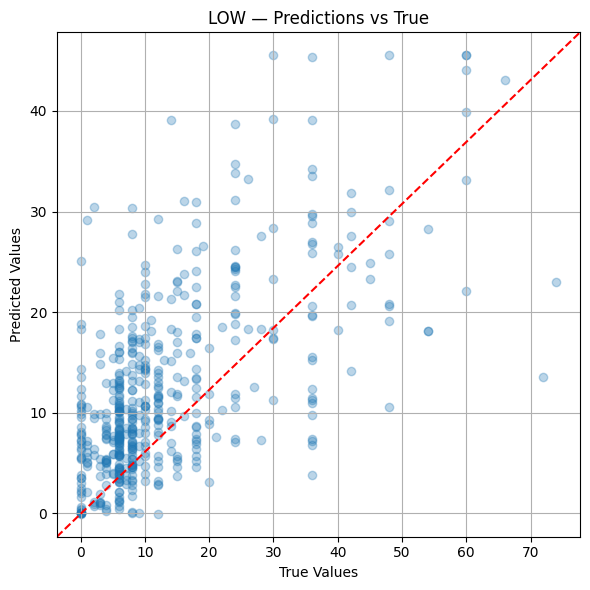

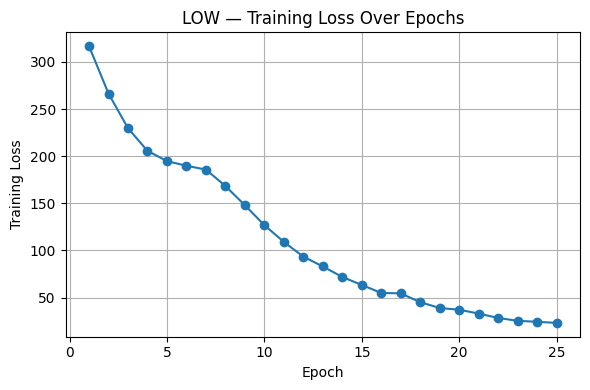


📊 LOW Evaluation:
MAE: 7.02
MSE: 106.40
R²: 0.39

🔍 Mean Relative Error: 565260.62 (0.50 median)
Over-predictions: 264, Under-predictions: 237

🔍 Top 10 Largest Errors:
True: 72.00, Pred: 13.56, Error: 58.44
True: 74.00, Pred: 22.97, Error: 51.03
True: 60.00, Pred: 22.13, Error: 37.87
True: 48.00, Pred: 10.60, Error: 37.40
True: 54.00, Pred: 18.13, Error: 35.87
True: 54.00, Pred: 18.14, Error: 35.86
True: 36.00, Pred: 3.85, Error: 32.15
True: 36.00, Pred: 6.77, Error: 29.23
True: 48.00, Pred: 19.14, Error: 28.86
True: 36.00, Pred: 7.19, Error: 28.81


Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Saved model to: /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment/low

=== 🔧 Training for: HIGH ===


high Epoch 1: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


high Epoch 1 Loss: 1136.2618


high Epoch 2: 100%|██████████| 225/225 [00:27<00:00,  8.15it/s]


high Epoch 2 Loss: 1006.8128


high Epoch 3: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


high Epoch 3 Loss: 867.7354


high Epoch 4: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


high Epoch 4 Loss: 728.4828


high Epoch 5: 100%|██████████| 225/225 [00:27<00:00,  8.16it/s]


high Epoch 5 Loss: 614.3697


high Epoch 6: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


high Epoch 6 Loss: 531.9475


high Epoch 7: 100%|██████████| 225/225 [00:27<00:00,  8.17it/s]


high Epoch 7 Loss: 484.3773


high Epoch 8: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


high Epoch 8 Loss: 459.7913


high Epoch 9: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


high Epoch 9 Loss: 449.1917


high Epoch 10: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


high Epoch 10 Loss: 448.7751


high Epoch 11: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


high Epoch 11 Loss: 442.4400


high Epoch 12: 100%|██████████| 225/225 [00:27<00:00,  8.14it/s]


high Epoch 12 Loss: 434.9271


high Epoch 13: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


high Epoch 13 Loss: 421.3585


high Epoch 14: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


high Epoch 14 Loss: 389.4930


high Epoch 15: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


high Epoch 15 Loss: 342.3066


high Epoch 16: 100%|██████████| 225/225 [00:27<00:00,  8.06it/s]


high Epoch 16 Loss: 309.9414


high Epoch 17: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


high Epoch 17 Loss: 274.9457


high Epoch 18: 100%|██████████| 225/225 [00:27<00:00,  8.09it/s]


high Epoch 18 Loss: 226.7961


high Epoch 19: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


high Epoch 19 Loss: 192.7706


high Epoch 20: 100%|██████████| 225/225 [00:27<00:00,  8.09it/s]


high Epoch 20 Loss: 163.1177


high Epoch 21: 100%|██████████| 225/225 [00:27<00:00,  8.13it/s]


high Epoch 21 Loss: 151.8631


high Epoch 22: 100%|██████████| 225/225 [00:27<00:00,  8.11it/s]


high Epoch 22 Loss: 128.1486


high Epoch 23: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


high Epoch 23 Loss: 120.3554


high Epoch 24: 100%|██████████| 225/225 [00:27<00:00,  8.10it/s]


high Epoch 24 Loss: 109.8077


high Epoch 25: 100%|██████████| 225/225 [00:27<00:00,  8.08it/s]


high Epoch 25 Loss: 100.9438


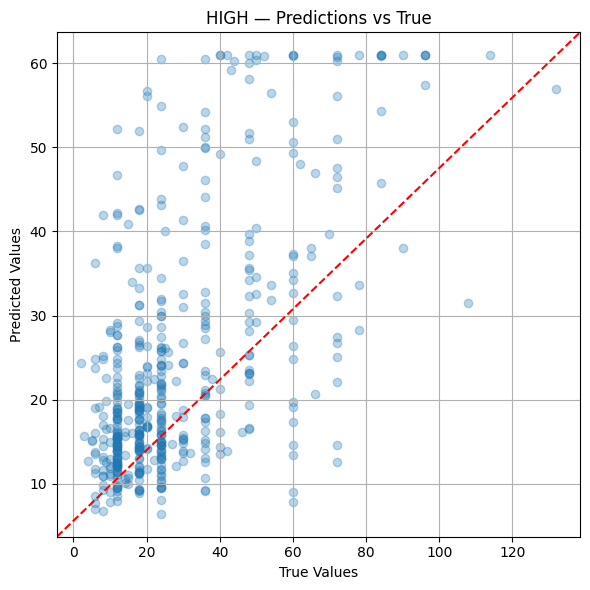

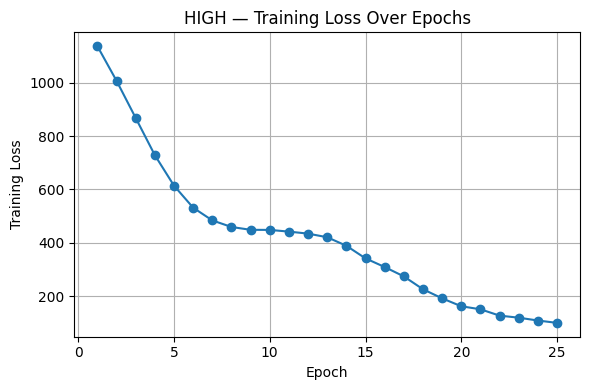


📊 HIGH Evaluation:
MAE: 11.91
MSE: 289.78
R²: 0.32

🔍 Mean Relative Error: 0.50 (0.35 median)
Over-predictions: 230, Under-predictions: 271

🔍 Top 10 Largest Errors:
True: 108.00, Pred: 31.49, Error: 76.51
True: 132.00, Pred: 56.96, Error: 75.04
True: 72.00, Pred: 12.56, Error: 59.44
True: 72.00, Pred: 14.61, Error: 57.39
True: 114.00, Pred: 60.94, Error: 53.06
True: 60.00, Pred: 7.90, Error: 52.10
True: 90.00, Pred: 38.04, Error: 51.96
True: 60.00, Pred: 9.04, Error: 50.96
True: 72.00, Pred: 22.08, Error: 49.92
True: 78.00, Pred: 28.27, Error: 49.73
✅ Saved model to: /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment/high


In [4]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig, BertPreTrainedModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== Model and Tokenizer Setup ==========
model_path = "/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Tokenization ==========
def tokenize_single_window(text, tokenizer, max_length=512):
    return tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

# ========== Dataset ==========
class PunishmentDataset(Dataset):
    def __init__(self, df, tokenizer, target_col):
        self.texts = df["text"].tolist()
        self.labels = df[target_col].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenize_single_window(self.texts[idx], self.tokenizer)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label
        }

# ========== Collate ==========
def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch])
    }

# ========== Model ==========
class HeBERTRegressor(BertPreTrainedModel):
    def __init__(self, config, model_path):
        super().__init__(config)
        self.bert = AutoModel.from_pretrained(model_path)
        self.regressor = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
        self.init_weights()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.regressor(cls_output).squeeze(1)
        loss_fn = nn.MSELoss()
        loss = loss_fn(logits, labels) if labels is not None else torch.tensor(0.0, device=logits.device)
        return {"loss": loss, "logits": logits}

# ========== Load Data ==========
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])
df["text"] = df["extracted_gpt_facts"]

# ========== Plots ==========
def plot_predictions(trues, preds, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(trues, preds, alpha=0.3)
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{title} — Predictions vs True")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_loss_curve(losses, title):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title(f"{title} — Training Loss Over Epochs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ========== Training ==========
def train_and_eval(target_col):
    print(f"\n=== 🔧 Training for: {target_col.upper()} ===")

    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

    train_dataset = PunishmentDataset(train_df, tokenizer, target_col)
    test_dataset = PunishmentDataset(test_df, tokenizer, target_col)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

    config = AutoConfig.from_pretrained(model_path)
    model = HeBERTRegressor(config, model_path).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    best_val_loss = float("inf")
    patience = 5
    wait = 0
    epoch_losses = []

    for epoch in range(25):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"{target_col} Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{target_col} Epoch {epoch+1} Loss: {avg_loss:.4f}")

        # Early stopping placeholder (no validation here)
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # --- Evaluation ---
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds.extend(outputs["logits"].cpu().numpy())
            trues.extend(labels.cpu().numpy())

    preds, trues = np.array(preds), np.array(trues)
    mae = mean_absolute_error(trues, preds)
    mse = mean_squared_error(trues, preds)
    r2 = r2_score(trues, preds)
    plot_predictions(trues, preds, target_col.upper())
    plot_loss_curve(epoch_losses, target_col.upper())

    print(f"\n📊 {target_col.upper()} Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R²: {r2:.2f}")

    # 🔍 Error analysis
    errors = np.abs(trues - preds)
    relative_errors = errors / np.maximum(trues, 1e-6)
    print(f"\n🔍 Mean Relative Error: {np.mean(relative_errors):.2f} ({np.median(relative_errors):.2f} median)")

    over_preds = np.sum(preds > trues)
    under_preds = np.sum(preds < trues)
    print(f"Over-predictions: {over_preds}, Under-predictions: {under_preds}")

    top_k = 10
    worst_indices = errors.argsort()[-top_k:][::-1]
    print(f"\n🔍 Top {top_k} Largest Errors:")
    for i in worst_indices:
        print(f"True: {trues[i]:.2f}, Pred: {preds[i]:.2f}, Error: {errors[i]:.2f}")

    save_path = f"/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment/{target_col}"
    model.bert.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    torch.save(model.regressor.state_dict(), f"{save_path}/regressor.pt")
    print(f"✅ Saved model to: {save_path}")

for col in ["low", "high"]:
    train_and_eval(col)


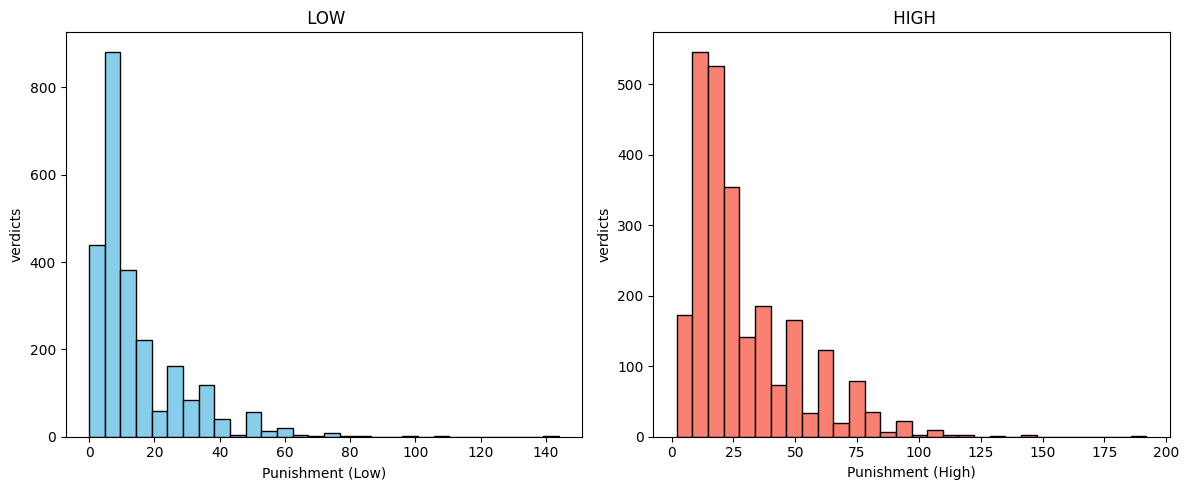

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# טען את הקובץ (שנה את הנתיב לפי הצורך)
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])

# פלוט
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df["low"], bins=30, color="skyblue", edgecolor="black")
plt.title(" LOW")
plt.xlabel("Punishment (Low)")
plt.ylabel("verdicts")

plt.subplot(1, 2, 2)
plt.hist(df["high"], bins=30, color="salmon", edgecolor="black")
plt.title(" HIGH")
plt.xlabel("Punishment (High)")
plt.ylabel("verdicts")

plt.tight_layout()
plt.show()


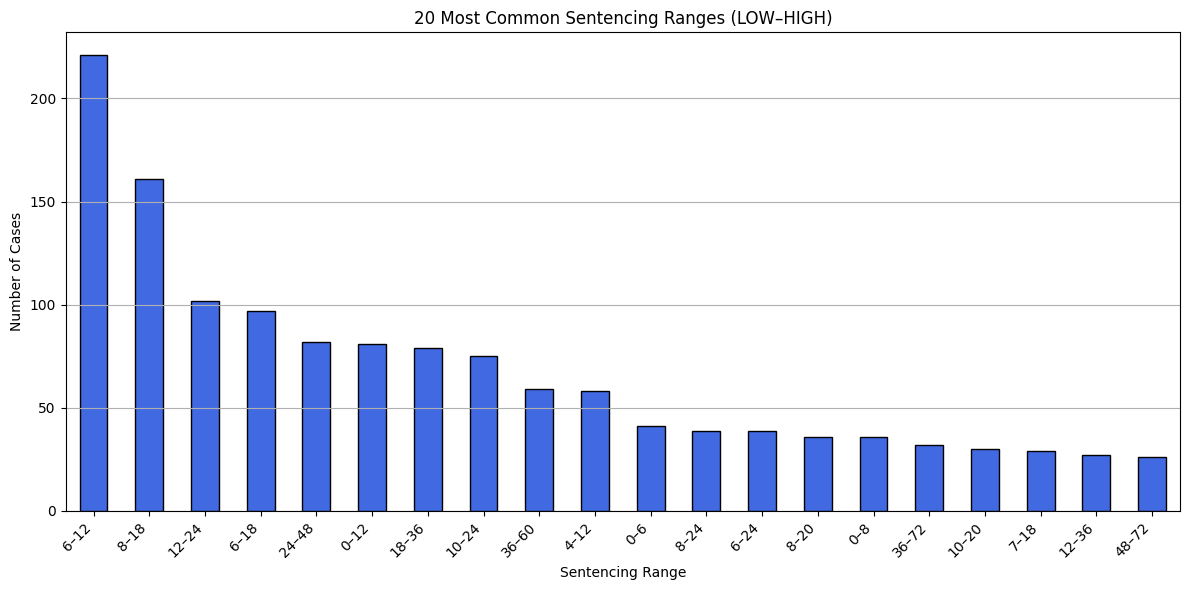

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# טען את הקובץ
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])

# יצירת עמודת טווח טקסטואלי: "low–high"
df["range_str"] = df["low"].astype(int).astype(str) + "–" + df["high"].astype(int).astype(str)

# ספירה של כל טווח כזה
range_counts = df["range_str"].value_counts().sort_values(ascending=False)

# פלוט של 20 הטווחים הכי נפוצים
plt.figure(figsize=(12, 6))
range_counts.head(20).plot(kind="bar", color="royalblue", edgecolor="black")
plt.title("20 Most Common Sentencing Ranges (LOW–HIGH)")
plt.xlabel("Sentencing Range")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


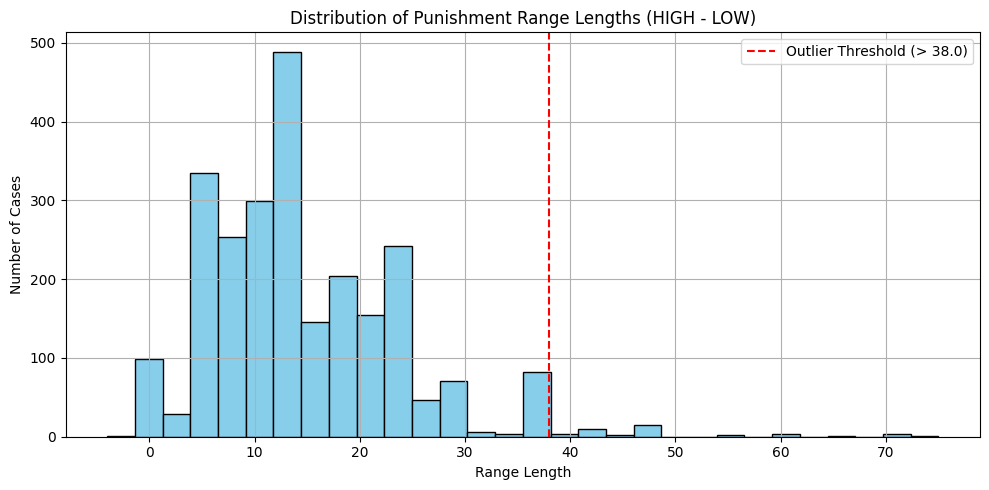

===== Summary =====
Outlier threshold: 38.00
🔴 Number of cases with outlier range length: 41
🟣 Number of unique (LOW–HIGH) ranges that appear only once: 148

🟣 Example of rare ranges:
range_str
42–54    1
8–30     1
28–36    1
48–48    1
22–46    1
12–40    1
13–26    1
26–40    1
11–29    1
60–60    1
Name: count, dtype: int64


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])

# Compute range length
df["range_len"] = df["high"] - df["low"]

# Detect outliers using IQR
Q1 = df["range_len"].quantile(0.25)
Q3 = df["range_len"].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
outliers = df[df["range_len"] > threshold]

# Create string representation of ranges
df["range_str"] = df["low"].astype(int).astype(str) + "–" + df["high"].astype(int).astype(str)

# Count rare ranges (appear once)
rare_ranges = df["range_str"].value_counts()
rare_ranges = rare_ranges[rare_ranges < 2]

# === Plot: range length distribution ===
plt.figure(figsize=(10, 5))
plt.hist(df["range_len"], bins=30, color="skyblue", edgecolor="black")
plt.axvline(threshold, color="red", linestyle="--", label=f"Outlier Threshold (> {threshold:.1f})")
plt.title("Distribution of Punishment Range Lengths (HIGH - LOW)")
plt.xlabel("Range Length")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print results ===
print("===== Summary =====")
print(f"Outlier threshold: {threshold:.2f}")
print(f"🔴 Number of cases with outlier range length: {len(outliers)}")
print(f"🟣 Number of unique (LOW–HIGH) ranges that appear only once: {len(rare_ranges)}")

# Optionally: print some rare values
print("\n🟣 Example of rare ranges:")
print(rare_ranges.head(10))


In [12]:
import pandas as pd

# Load dataset
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])

# Count exact punishment cases (no range)
exact_cases = df[df["low"] == df["high"]]
print(f"📌 Number of cases where LOW == HIGH (exact punishment): {len(exact_cases)}")


📌 Number of cases where LOW == HIGH (exact punishment): 92


In [13]:
import pandas as pd

# Load and filter dataset
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])

# Count exact punishments
exact_cases = df[df["low"] == df["high"]]
N_exact = len(exact_cases)

# Create range string
df["range_str"] = df["low"].astype(int).astype(str) + "–" + df["high"].astype(int).astype(str)

# Identify rare ranges
range_counts = df["range_str"].value_counts()
rare_range_values = range_counts[range_counts < 2].index
rare_cases = df[df["range_str"].isin(rare_range_values)]
N_rare = len(rare_cases)

# Total remaining after removing both
N_total = len(df)
N_clean = N_total - N_exact - N_rare

print("===== Filtering Summary =====")
print(f"Total cases: {N_total}")
print(f"Exact punishment cases (low == high): {N_exact}")
print(f"Rare range cases (appeared once): {N_rare}")
print(f"✅ Cases remaining (with valid, common range): {N_clean}")


===== Filtering Summary =====
Total cases: 2502
Exact punishment cases (low == high): 92
Rare range cases (appeared once): 148
✅ Cases remaining (with valid, common range): 2262


Low:  min = 0.0 , max = 72.0 , mean = 13.331571994715985
High: min = 2.0 , max = 120.0 , mean = 28.25715543813298


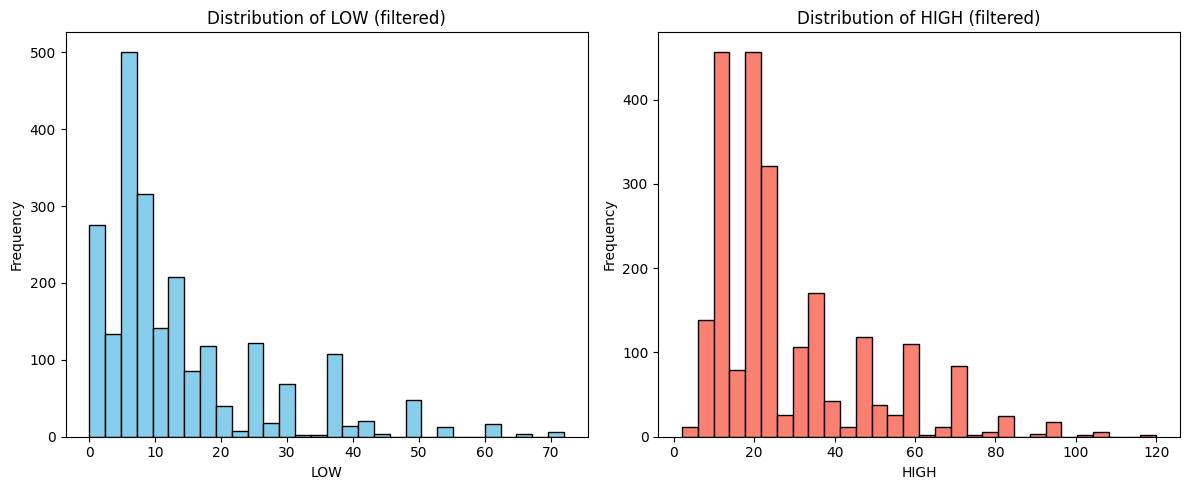

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and filter
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])
df["range_str"] = df["low"].astype(int).astype(str) + "–" + df["high"].astype(int).astype(str)

# Remove rare and exact
range_counts = df["range_str"].value_counts()
rare_ranges = range_counts[range_counts < 2].index
df = df[~df["range_str"].isin(rare_ranges) & (df["low"] != df["high"])]

# Print basic stats
print("Low:  min =", df['low'].min(), ", max =", df['low'].max(), ", mean =", df['low'].mean())
print("High: min =", df['high'].min(), ", max =", df['high'].max(), ", mean =", df['high'].mean())

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df["low"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of LOW (filtered)")
plt.xlabel("LOW")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df["high"], bins=30, color="salmon", edgecolor="black")
plt.title("Distribution of HIGH (filtered)")
plt.xlabel("HIGH")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig, BertPreTrainedModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== Setup ==========
model_path = "/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantiles = [0.1, 0.5, 0.9]

# ========== Tokenization ==========
def tokenize_single_window(text, tokenizer, max_length=512):
    return tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

# ========== Dataset ==========
class PunishmentDataset(Dataset):
    def __init__(self, df, tokenizer, target_col):
        self.texts = df["text"].tolist()
        self.labels = df[target_col].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenize_single_window(self.texts[idx], self.tokenizer)
        label = torch.tensor([self.labels[idx]], dtype=torch.float)  # wrapped in list to make 2D
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label
        }

# ========== Collate ==========
def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch])
    }

# ========== Quantile Loss ==========
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            loss = torch.max((q - 1) * errors, q * errors)
            losses.append(loss.unsqueeze(1))
        loss_tensor = torch.cat(losses, dim=1)
        return loss_tensor.mean()

# ========== Model ==========
class HeBERTQuantileRegressor(BertPreTrainedModel):
    def __init__(self, config, model_path, quantiles):
        super().__init__(config)
        self.quantiles = quantiles
        self.bert = AutoModel.from_pretrained(model_path)
        self.regressor = nn.Sequential(
            nn.Linear(config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, len(quantiles))
        )
        self.init_weights()
        self.loss_fn = QuantileLoss(quantiles)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.regressor(cls_output)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        else:
            loss = torch.tensor(0.0, device=logits.device)
        return {"loss": loss, "logits": logits}

# ========== Data ==========
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])
df["text"] = df["extracted_gpt_facts"]

# ========== Training & Evaluation ==========
def train_and_eval(target_col):
    print(f"\n=== 🔧 Training for: {target_col.upper()} ===")

    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

    train_dataset = PunishmentDataset(train_df, tokenizer, target_col)
    test_dataset = PunishmentDataset(test_df, tokenizer, target_col)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

    config = AutoConfig.from_pretrained(model_path)
    model = HeBERTQuantileRegressor(config, model_path, quantiles).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    epoch_losses = []
    for epoch in range(15):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"{target_col} Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs["loss"]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"{target_col} Epoch {epoch+1} Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = outputs["logits"].cpu().numpy()
            preds.append(pred)
            trues.append(labels.cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues).flatten()
    median_preds = preds[:, quantiles.index(0.5)]

    print(f"\n📊 {target_col.upper()} Evaluation:")
    print(f"MAE: {mean_absolute_error(trues, median_preds):.2f}")
    print(f"MSE: {mean_squared_error(trues, median_preds):.2f}")
    print(f"R²: {r2_score(trues, median_preds):.2f}")

    save_path = f"/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment/{target_col}_quantile"
    model.bert.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    torch.save(model.regressor.state_dict(), f"{save_path}/regressor.pt")
    print(f"✅ Saved model to: {save_path}")

for col in ["low", "high"]:
    train_and_eval(col)

Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== 🔧 Training for: LOW ===


low Epoch 1: 100%|██████████| 225/225 [00:25<00:00,  8.96it/s]


low Epoch 1 Loss: 6.2214


low Epoch 2: 100%|██████████| 225/225 [00:25<00:00,  8.78it/s]


low Epoch 2 Loss: 5.3767


low Epoch 3: 100%|██████████| 225/225 [00:25<00:00,  8.69it/s]


low Epoch 3 Loss: 4.6269


low Epoch 4: 100%|██████████| 225/225 [00:26<00:00,  8.64it/s]


low Epoch 4 Loss: 4.0609


low Epoch 5: 100%|██████████| 225/225 [00:26<00:00,  8.58it/s]


low Epoch 5 Loss: 3.7401


low Epoch 6: 100%|██████████| 225/225 [00:26<00:00,  8.58it/s]


low Epoch 6 Loss: 3.5404


low Epoch 7: 100%|██████████| 225/225 [00:26<00:00,  8.54it/s]


low Epoch 7 Loss: 3.3952


low Epoch 8: 100%|██████████| 225/225 [00:26<00:00,  8.47it/s]


low Epoch 8 Loss: 3.2941


low Epoch 9: 100%|██████████| 225/225 [00:26<00:00,  8.48it/s]


low Epoch 9 Loss: 3.2100


low Epoch 10: 100%|██████████| 225/225 [00:26<00:00,  8.50it/s]


low Epoch 10 Loss: 3.1638


low Epoch 11: 100%|██████████| 225/225 [00:26<00:00,  8.51it/s]


low Epoch 11 Loss: 3.1302


low Epoch 12: 100%|██████████| 225/225 [00:26<00:00,  8.53it/s]


low Epoch 12 Loss: 3.1085


low Epoch 13: 100%|██████████| 225/225 [00:26<00:00,  8.50it/s]


low Epoch 13 Loss: 3.0920


low Epoch 14: 100%|██████████| 225/225 [00:26<00:00,  8.46it/s]


low Epoch 14 Loss: 3.0809


low Epoch 15: 100%|██████████| 225/225 [00:26<00:00,  8.51it/s]


low Epoch 15 Loss: 3.0807

📊 LOW Evaluation:
MAE: 8.63
MSE: 191.37
R²: -0.09


Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Saved model to: /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment/low_quantile

=== 🔧 Training for: HIGH ===


high Epoch 1: 100%|██████████| 225/225 [00:26<00:00,  8.47it/s]


high Epoch 1 Loss: 13.2787


high Epoch 2: 100%|██████████| 225/225 [00:26<00:00,  8.49it/s]


high Epoch 2 Loss: 11.9052


high Epoch 3: 100%|██████████| 225/225 [00:26<00:00,  8.49it/s]


high Epoch 3 Loss: 10.1327


high Epoch 4:  13%|█▎        | 29/225 [00:03<00:23,  8.24it/s]


KeyboardInterrupt: 

Multitask

Some weights of BertModel were not initialized from the model checkpoint at /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== 🔧 Training Multi-Output Model for Punishment Range ===


Epoch 1: 100%|██████████| 225/225 [00:24<00:00,  9.03it/s]


Epoch 1 Loss: 1674.9346


Epoch 2: 100%|██████████| 225/225 [00:25<00:00,  8.84it/s]


Epoch 2 Loss: 1507.3110


Epoch 3: 100%|██████████| 225/225 [00:25<00:00,  8.73it/s]


Epoch 3 Loss: 1315.4425


Epoch 4: 100%|██████████| 225/225 [00:26<00:00,  8.63it/s]


Epoch 4 Loss: 1121.0267


Epoch 5: 100%|██████████| 225/225 [00:26<00:00,  8.57it/s]


Epoch 5 Loss: 954.9321


Epoch 6: 100%|██████████| 225/225 [00:26<00:00,  8.51it/s]


Epoch 6 Loss: 835.2077


Epoch 7: 100%|██████████| 225/225 [00:26<00:00,  8.45it/s]


Epoch 7 Loss: 761.8194


Epoch 8: 100%|██████████| 225/225 [00:26<00:00,  8.45it/s]


Epoch 8 Loss: 727.3380


Epoch 9: 100%|██████████| 225/225 [00:26<00:00,  8.41it/s]


Epoch 9 Loss: 697.0798


Epoch 10: 100%|██████████| 225/225 [00:26<00:00,  8.45it/s]


Epoch 10 Loss: 630.9313


Epoch 11: 100%|██████████| 225/225 [00:26<00:00,  8.40it/s]


Epoch 11 Loss: 535.4286


Epoch 12: 100%|██████████| 225/225 [00:26<00:00,  8.40it/s]


Epoch 12 Loss: 456.4363


Epoch 13: 100%|██████████| 225/225 [00:26<00:00,  8.39it/s]


Epoch 13 Loss: 383.5170


Epoch 14: 100%|██████████| 225/225 [00:26<00:00,  8.42it/s]


Epoch 14 Loss: 333.0819


Epoch 15: 100%|██████████| 225/225 [00:26<00:00,  8.41it/s]


Epoch 15 Loss: 284.0865


Epoch 16: 100%|██████████| 225/225 [00:26<00:00,  8.41it/s]


Epoch 16 Loss: 251.2267


Epoch 17: 100%|██████████| 225/225 [00:26<00:00,  8.40it/s]


Epoch 17 Loss: 222.9627


Epoch 18: 100%|██████████| 225/225 [00:26<00:00,  8.38it/s]


Epoch 18 Loss: 192.6000


Epoch 19: 100%|██████████| 225/225 [00:26<00:00,  8.39it/s]


Epoch 19 Loss: 174.0988


Epoch 20: 100%|██████████| 225/225 [00:26<00:00,  8.40it/s]


Epoch 20 Loss: 153.6837


Epoch 21: 100%|██████████| 225/225 [00:26<00:00,  8.40it/s]


Epoch 21 Loss: 140.6770


Epoch 22: 100%|██████████| 225/225 [00:26<00:00,  8.38it/s]


Epoch 22 Loss: 134.3538


Epoch 23: 100%|██████████| 225/225 [00:26<00:00,  8.38it/s]


Epoch 23 Loss: 133.4661


Epoch 24: 100%|██████████| 225/225 [00:26<00:00,  8.40it/s]


Epoch 24 Loss: 116.3583


Epoch 25: 100%|██████████| 225/225 [00:26<00:00,  8.42it/s]


Epoch 25 Loss: 109.8149

📊 Evaluation:
LOW - MAE: 7.31, MSE: 117.90, R²: 0.33
HIGH - MAE: 12.21, MSE: 303.21, R²: 0.29
RANGE - MAE: 6.05, MSE: 76.27, R²: 0.13
✅ Saved model to: /home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment/joint_low_high


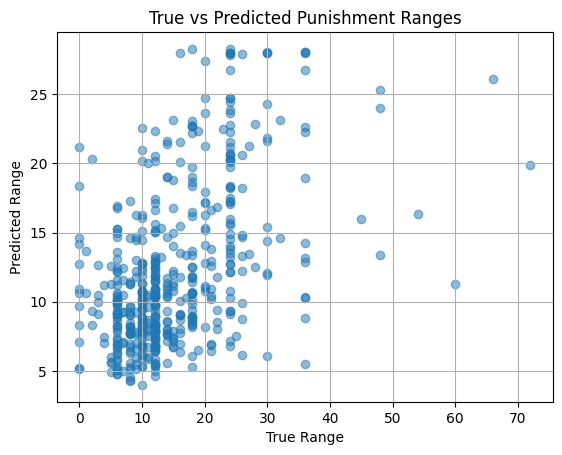

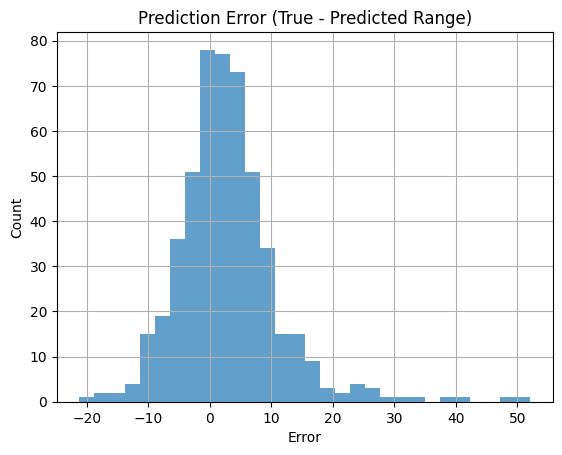

In [7]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig, BertPreTrainedModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========== Setup ==========
model_path = "/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs/final"
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Tokenization ==========
def tokenize_single_window(text, tokenizer, max_length=512):
    return tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

# ========== Dataset ==========
class PunishmentDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df["text"].tolist()
        self.lows = df["low"].tolist()
        self.highs = df["high"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenize_single_window(self.texts[idx], self.tokenizer)
        low = torch.tensor([self.lows[idx]], dtype=torch.float)
        high = torch.tensor([self.highs[idx]], dtype=torch.float)
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "low": low,
            "high": high
        }

# ========== Collate ==========
def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "low": torch.cat([x["low"] for x in batch], dim=0),
        "high": torch.cat([x["high"] for x in batch], dim=0)
    }

# ========== Model ==========
class HeBERTMultiOutputRegressor(BertPreTrainedModel):
    def __init__(self, config, model_path):
        super().__init__(config)
        self.bert = AutoModel.from_pretrained(model_path)
        self.regressor = nn.Sequential(
            nn.Linear(config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)  # two outputs: low and high
        )
        self.init_weights()
        self.loss_fn = nn.MSELoss()

    def forward(self, input_ids, attention_mask, low=None, high=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.regressor(cls_output)  # shape: [batch, 2]
        pred_low = logits[:, 0]
        pred_high = logits[:, 1]

        if low is not None and high is not None:
            loss_low = self.loss_fn(pred_low, low)
            loss_high = self.loss_fn(pred_high, high)
            spread_penalty = torch.mean(torch.relu(pred_low - pred_high) ** 2)
            weighted_error = torch.mean(torch.abs(pred_low - low) ** 2 + torch.abs(pred_high - high) ** 2)
            loss = loss_low + loss_high + 0.2 * spread_penalty + 0.1 * weighted_error
        else:
            loss = torch.tensor(0.0, device=logits.device)

        return {"loss": loss, "pred_low": pred_low, "pred_high": pred_high}

# ========== Data ==========
df = pd.read_csv("merged_output.csv")
df = df.dropna(subset=["extracted_gpt_facts", "low", "high"])
df["text"] = df["extracted_gpt_facts"]

# ========== Training & Evaluation ==========
def train_and_eval():
    print(f"\n=== 🔧 Training Multi-Output Model for Punishment Range ===")

    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

    train_dataset = PunishmentDataset(train_df, tokenizer)
    test_dataset = PunishmentDataset(test_df, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

    config = AutoConfig.from_pretrained(model_path)
    model = HeBERTMultiOutputRegressor(config, model_path).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    for epoch in range(25):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            low = batch["low"].to(device)
            high = batch["high"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, low=low, high=high)
            loss = outputs["loss"]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    pred_lows, pred_highs, true_lows, true_highs = [], [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            low = batch["low"].to(device)
            high = batch["high"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_lows.append(outputs["pred_low"].cpu().numpy())
            pred_highs.append(outputs["pred_high"].cpu().numpy())
            true_lows.append(low.cpu().numpy())
            true_highs.append(high.cpu().numpy())

    pred_lows = np.concatenate(pred_lows)
    pred_highs = np.concatenate(pred_highs)
    true_lows = np.concatenate(true_lows)
    true_highs = np.concatenate(true_highs)

    pred_ranges = pred_highs - pred_lows
    true_ranges = true_highs - true_lows

    print("\n📊 Evaluation:")
    print(f"LOW - MAE: {mean_absolute_error(true_lows, pred_lows):.2f}, MSE: {mean_squared_error(true_lows, pred_lows):.2f}, R²: {r2_score(true_lows, pred_lows):.2f}")
    print(f"HIGH - MAE: {mean_absolute_error(true_highs, pred_highs):.2f}, MSE: {mean_squared_error(true_highs, pred_highs):.2f}, R²: {r2_score(true_highs, pred_highs):.2f}")
    print(f"RANGE - MAE: {mean_absolute_error(true_ranges, pred_ranges):.2f}, MSE: {mean_squared_error(true_ranges, pred_ranges):.2f}, R²: {r2_score(true_ranges, pred_ranges):.2f}")

    # ========== Plots ==========
    plt.figure()
    plt.scatter(true_ranges, pred_ranges, alpha=0.5)
    plt.xlabel("True Range")
    plt.ylabel("Predicted Range")
    plt.title("True vs Predicted Punishment Ranges")
    plt.grid(True)
    plt.savefig("range_scatter_plot.png")

    plt.figure()
    plt.hist(true_ranges - pred_ranges, bins=30, alpha=0.7)
    plt.title("Prediction Error (True - Predicted Range)")
    plt.xlabel("Error")
    plt.ylabel("Count")
    plt.grid(True)
    plt.savefig("range_error_histogram.png")

    save_path = f"/home/liorkob/M.Sc/thesis/pre-train/hebert-mlm-3k-drugs-punishment/joint_low_high"
    model.bert.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    torch.save(model.regressor.state_dict(), f"{save_path}/regressor.pt")
    print(f"✅ Saved model to: {save_path}")

train_and_eval()